Author: Zhendong Zhou, Linquan Ma, Wenjia Xie

# Abstract

   In this project, we build linear models for predicting body fat percentage. There are already various ways to estimate body fat percentage such as Katch and McArdle's model in 1977. However, some of the models are a little complicated which makes it hard for people to remember. Our aim of this project is to derive a simple, robust, accurate and precise "rule-of-thumb" model that can be calculated and interpreted easily. We present through a 4-step process:
   
   1. Data pre-processing
   
   2. Model construction
   
   3. Model diagnosis
   
   4. Discussion of model

# Step 1  Data Pre-processing

## Background and Data summary

   Body fat percentage reflects the risk of weight-related diseases. A variety of articles and reports give predictive equations for body fat percentage in terms of their circumference measurements. The data consists 252 men with their body fat percentage, age, weight, height, and various body circumference measurements.

## Outlier detection

   In this section, we detect all variables one by one, plot their histograms and view the extreme values to see if they are really ourliers. Here we just show the variables which are suspectable. Let's first take a look at bodyfat.

In [1]:
options(warn=-1) 
rm(list=ls())
data=read.csv("BodyFat.csv")

In [2]:
data[c(which(data$BODYFAT==0),which(data$BODYFAT>40)),]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
182,182,0.0,1.1089,40,118.5,68,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5
216,216,45.1,0.9950,51,219.0,64,37.6,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


From the output above, there are two outliers:

   For the 182nd record, it has zero body fat, which is impossible. Therefore, we delete the 182nd data point whose bodyfat was recorded as 0. For the 216th data point, chest and abdomen circumference are huge at the same time. Hence we consider the data correct. Next, we take a look at height.

In [3]:
data[which(data$HEIGHT<40),]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
42,42,31.7,1.025,44,205,29.5,29.9,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


   We can see that the 42nd man is about 29.5 inches tall, which is unrealistic, especially when he weights 205lbs. But his BMI is 29.8, which seems right. There must be something wrong when recording his height. So we compute height from both weight and BMI. After computation, the 42nd data point looks normal. At the same time, when we were examining other extreme values of other variables, we found that the 39th man was appeared frequently. It implies that the 39th data point is an outlier. But there is nothing wrong with this data point. So we won't delete it, and will discuss it in the remaining part. In summary, we only delete one data point, which is one with 0 bodyfat.

## Variable Selection

   Since the sample size is not large enough to build a persuasive model, we compare different models proposed by other researchers and select the one that fits our needs.

   We found different ways of bodyfat calculation, which are listed below:
https://www.active.com/fitness/calculators/bodyfat, https://www.omnicalculator.com/health/body-fat, http://www.bmi-calculator.net/body-fat-calculator/, 
https://www.verywellfit.com/how-to-use-body-fat-percentage-calculator-3858855. 
   
   These pages all indicates that weight and abdomen are most crucial to the calculation of body fat. From our perspective, it is also the most widely used model.

https://www.calculator.net/body-fat-calculator.html. 
   This page suggests that age, weight, height, neck, abdomen, hip are all needed for the calculation of body fat.

https://jianfei.39.net/box/bfr, 
   This page says that weight, height and age are crucial to the calculation;

   Above all, on considering that our aim is a "rule-of-thumb" model, the first set of variables provides us least variables, so we use weight and abdomen as our predictors.

# Step 2  Model construction

## Linear model

In [4]:
data1 <- data[-which(data$BODYFAT == 0), ]

   By using weight and abdomen, we can obtain the least square estimates:

In [5]:
lm1 <- lm(BODYFAT ~ ABDOMEN + WEIGHT, data = data1)
summary(lm1)


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT, data = data1)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.5556  -2.9920   0.0099   2.9368   9.7407 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -40.89988    2.42652 -16.855  < 2e-16 ***
ABDOMEN       0.91169    0.05246  17.377  < 2e-16 ***
WEIGHT       -0.13704    0.01923  -7.125 1.13e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.118 on 248 degrees of freedom
Multiple R-squared:  0.7143,	Adjusted R-squared:  0.712 
F-statistic: 310.1 on 2 and 248 DF,  p-value: < 2.2e-16


   From the summary, all the parameters are significant, with the p-value for abdomen to be $2\times 10^{-16}$, while the p-value for weight to be $1.13 \times 10^{-11}$, which means that the with the assumption that abodmen and weight should not be included into this linear model, the possibility that we accept this assumption is $2\times 10^{-16}$ and $1.13 \times 10^{-11}$ and we should definitely reject this hypothesis. And we also noticed that it's a model with $R^2 = 0.714$. Reminded that the full model has $R_{full} = 0.745$, which is not significantly larger than the $R^2$ in our model. We hence consider our model adequate.

## Making the model more robust to outliers

   As previously discussed, 39th patient is absolutely an outlier. Our aim is to make our model simple and robust. One of the common way in robust statistics is to change the loss function from square loss to Huber loss. Huber loss is actually a combination of absolute loss and square loss. It is square loss near the origin, and absolute loss otherwise. We choose the tuning parameter as the default parameter in the hqreg function.

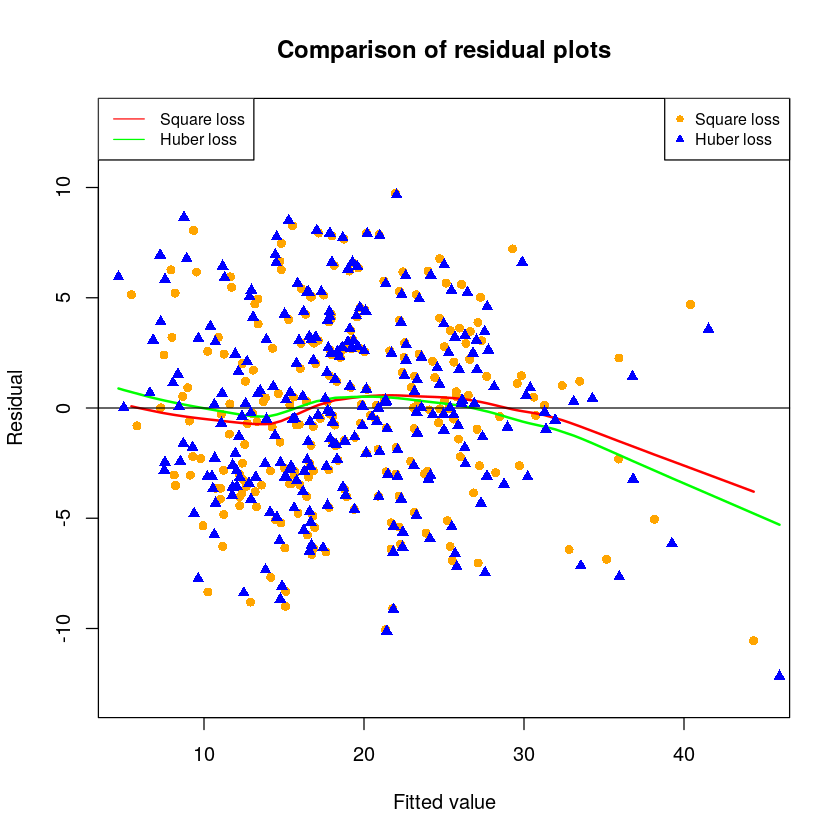

In [6]:
library(MASS)
library(hqreg)
warnings('off')

huber1 <- hqreg(cbind(data1$WEIGHT, data1$ABDOMEN), data1$BODYFAT, nlambda = 2, lambda.min = 0)
predict_huber <- predict(huber1, cbind(data1$WEIGHT, data1$ABDOMEN), lambda = 0)
lowess1 <- lowess(predict_huber, data1$BODYFAT - predict(huber1, cbind(data1$WEIGHT, data1$ABDOMEN), lambda = 0))
lowess2 <- lowess(predict(lm1), data1$BODYFAT - predict(lm1))
plot(predict(lm1), data1$BODYFAT - predict(lm1), ylim = c(-13, 13), xlim = c(5, 45), col = 'orange', pch = 16, xlab = 'Fitted value', ylab = 'Residual', main = 'Comparison of residual plots')
lines(lowess2$x, lowess2$y, col = 'red', lwd = 2)
lines(lowess1$x, lowess1$y, col = 'green', lwd = 2)
abline(h = 0)
points(predict_huber, data1$BODYFAT - predict_huber, ylim = c(-13, 13), xlim = c(5, 45), pch = 17, col = 'blue')
legend('topright', legend = c('Square loss', 'Huber loss'), pch = c(16, 17), col = c('orange', 'blue'), cex = 0.8)
legend('topleft', legend = c('Square loss', 'Huber loss'), lty = rep(1, 2), col = c('red', 'green'), cex = 0.8)

   The above plot shows the comparison between linear regression with square loss and Huber loss. We see that if bodyfat percentage is between 10 to 30, Huber loss have a better performance (the green line is closer to 0 as compared to the red line). This is because outliers has less impact under Huber loss. We consider the results under Huber loss as our final simple and robust method for predicting bodyfat percentage. The parameter were shown below:

   In summary, the formula we derived from the analysis is:$$ bodyfat(\%) = -0.15 * weight(lbs) + 0.95 * abdomen(cm) -44.4$$

# Step 3  Model diagnosis

   First we check the **Normality Assumption** using shapiro.test() function: with assumption that they are normal, the consequece below shows that with confidence coefficient = 0.05, we have no reason to reject the hypothesis, so we can say that the data are normal.

In [7]:
shapiro.test(data1$BODYFAT - predict(lm1))


	Shapiro-Wilk normality test

data:  data1$BODYFAT - predict(lm1)
W = 0.99264, p-value = 0.2486


   Then we go check the **Linearity Assumption** through residuals vs fitted values plot: The residuals vs fitted values plot shows no distinct patterns, which means there is no non-linear relation between predictors and outcomes. In another word, the simple linear model is approporiate.

   Finally let's check the **Equal Variance Assumption** through the residuals vs fitted values plot: It shows that the residuals appears to spread randomly along the range of fitted values, which means residuals are homoscedastic.

# Step 4  Discussion of Model

## Strengths

   The best thing of our model should be the improvement to our model's robustness, which we use huber loss instead of general loss function. And the influence is apparent that it performs better when body fat is between 10% - 30%.

   Another strength of our model is the simplicity: It only have two variables and both of them are easy to measure

## weakness

   Firstly, when we were doing data pre-processing, we delete data as little as possible to keep the original appearance of the data, but the consequence might be that there are outliers exising in the data influencing the outcome. Though we overcome it through changing loss function, but we don't know if it will work in a new data set and if we need to come up with a new method to deal with new potential problems.

   Secondly, we can only analyze our new model through residuals plot, the p-value and other statistics are hard to derive for there is no build-in function to do it like in **lm()** function.

## Rule of Thumb

   In summary, if you want to know your bodyfat percentage, you just need know your weight with lbs and abdomen with cm. Your weight times -0.15 plus your abdomen times 0.95, finally minus 44.4. The answer is your bodyfat percentage.

# Conclusion

1. The formula to calculate your body fat is $$ Bodyfat(\%) = -0.15 \times Weight(lbs) + 0.95 \times Abdomen(cm) -44.4$$

2. When applying huber loss fucntion, it performs better when bodyfat is between 10% and 30%

# Contribution

|    __Name__        | __Contribution__ |
| -------------:     | :--------------- |
|   Wenjia Xie       | Conducted the data pre-process part and finish part of the slides       |
|   Linquan Ma       | Constructed and improve the model and finish part of the slides         |
|   Zhendong Zhou    | Did diagnosis and finish the shiny app, together with jupyter notebook  |

# References

1. Calculate formula of Body Fat Percentage, 2019,retrieved from https://baike.baidu.com/item/%E4%BD%93%E8%84%82%E7%8E%87?fr=aladdin#1

2. Calculater of Body Fat Percentage, 2018, retrieved from https://jianfei.39.net/box/bfr

3. Calculater of Body Fat Percentage, 2015, retrieved from https://www.hiyd.com/tools/Bodyfat
